A generalized linear model (GLM) is a model that replaces a parameter of a likelihood
function with a linear model. 
But GLMs need not use Gaussian likelihoods. 

Any likelihood function can be used, and linear models can be attached to any or all of the parameters that
describe its shape. 

The principle of maximum entropy helps us choose likelihood functions,
by providing a way to use stated assumptions about constraints on the outcome variable to
choose the likelihood function that is the most conservative distribution compatible with
the known constraints. 
Using this principle recovers all the most common likelihood functions
of many statistical approaches, Bayesian or not, while simultaneously providing a clear
rationale for choice among them.





The Gaussian models of previous chapters worked by first assuming a Gaussian distribution
over outcomes. Then, we replaced the parameter that defines the mean of that distribution,
μ, with a linear model. This resulted in likelihood definitions of the sort:
yi ∼ Normal(μi, σ)
μi = α + βxi
For an outcome variable that is continuous and far from any theoretical maximum or minimum,
this sort of Gaussian model has maximum entropy.
But when the outcome variable is either discrete or bounded, a Gaussian likelihood is
not the most powerful choice. Consider for example a count outcome, such as the number
of blue marbles pulled from a bag. Such a variable is constrained to be zero or a positive
integer. Using a Gaussian model with such a variable won’t result in a terrifying explosion.
But it can’t be trusted to do much more than estimate the average count. It certainly can’t
be trusted to produce sensible predictions, because while you and I know that counts can’t
be negative, a linear regression model does not. So it would happily predict negative values,
whenever the mean count is close to zero.

Luckily, it’s easy to do better. 
By using all of our prior knowledge about the outcome
variable, usually in the form of constraints on the possible values it can take, we can appeal
to maximum entropy for the choice of distribution. 
Then all we have to do is generalize the
linear regression strategy—replace a parameter describing the shape of the likelihood with a
linear model—to probability distributions other than the Gaussian.
This is the essence of a generalized linear model. And it results in models that
look like this:

yi ∼ Binomial(n, pi)

f (pi) = α + β(xi − ¯x)

f 
represents a link function, to be determined separately from the choice of distribution.

Generalized linear models need a link function, because rarely is there a “μ”, a parameter
describing the average outcome, and rarely are parameters unbounded in both directions,
like μ is. 

For example, the shape of the binomial distribution is determined, like the Gaussian,
by two parameters.
But unlike the Gaussian, neither of these parameters is the mean. 

Instead,

the mean outcome is np, which is a function of both parameters. 

Since n is usually known
(but not always), it is most common to attach a linear model to the unknown part, p. But p is
a probability mass, so pi must lie between zero and one. 

But there’s nothing to stop the linear
model α + βxi from falling below zero or exceeding one.

The link function f provides a solution to this common problem.

<h2>Exponential family<h2>
    
Minimum ? with subject to Maximum Entropy
    

    

<b>The exponential distribution</b>is constrained to be zero or positive.

It is a fundamental distribution of <b>distance and duration </b>, kinds of measurements that represent
displacement from some point of reference, either in time or space. 

If the probability of an event is constant in time or across space, then the distribution of events tends towards
exponential. 
The exponential distribution has maximum entropy among all non-negative
continuous distributions with the same average displacement. Its shape is described by a
single parameter, the rate of events λ, or the average displacement λ−1.

<b>The gamma distribution </b>  is also constrained to be zero or positive. 
It too
is a fundamental distribution of<b>distance and duration<b>.

But unlike the exponential distribution,the gamma distribution can have 

<b>a peak above zero<b>. 

If an event can only happen after
two or more exponentially distributed events happen, the resulting waiting times will be
gamma distributed.

For example, age of cancer onset is approximately gamma distributed,
since multiple events are necessary for onset.
The gamma distribution has maximum entropy
among all distributions with the same mean and same average logarithm. 

Its shape
is described by two parameters The gamma distribution
is common in survival and event history analysis, as well as some contexts in which a
continuous measurement is constrained to be positive.

<b>The Poisson distribution</b>  is a count distribution like the binomial. actually a special case of the binomial, mathematically. If the number of 

trials n is very large (and usually unknown) 

and the probability of a 

success p is very small,

then a binomial
distribution converges to a Poisson distribution with an expected rate of events per unit time
of λ = np. Practically, the Poisson distribution is used for counts that never get close to any
theoretical maximum. 


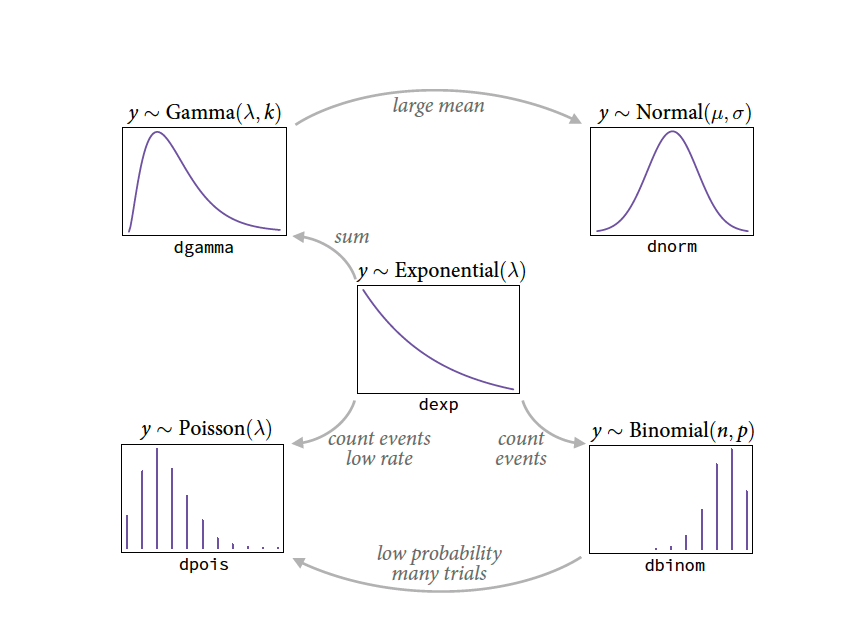

<h2>link function<h2>

To build a regression model from any of the exponential family distributions is just a matter of attaching one or more linear models
to one or more of the parameters that describe the distribution’s shape. 

But as hinted at earlier, usually we require a link function to prevent mathematical accidents like negative
distances or probability masses that exceed 1.

But what function should f be? A link function’s job is to map the linear space of a model
like α + β(xi − ¯x) onto the non-linear space of a parameter like θ. So f is chosen with that
goal in mind. Most of the time, for most GLMs, you can use one of two exceedingly common
links, a logit link or a log link

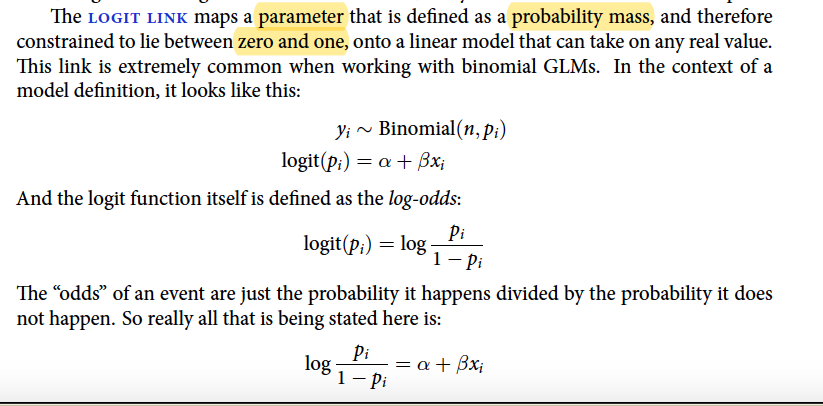

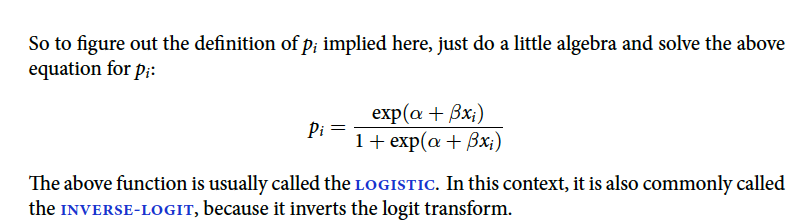

What all of this means is that when you use a logit link for a parameter, you are defining
the parameter’s value to be the logistic transform of the linear model.

The second very common link function is the   <h2>log link </h2>.
This link function maps a
parameter that is defined over

only positive real values onto a linear model.

For example,
suppose we want to model the standard deviation σ of a Gaussian distribution so it is a
function of a predictor variable x. The parameter σ must be positive, because a standard
deviation cannot be negative nor can it be zero. The model might look like:

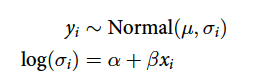

A log link is both conventional and useful in this situation. It prevents σ from taking on a
negative value.
What the log link effectively assumes is that the parameter’s value is the exponentiation
of the linear model. Solving log(σi) = α + βxi for σi yields the inverse link:

σi = exp(α + βxi)



<h1> Binomial regression</h1>
models for counts.
Counts
are non-negative integers—0, 1, 2, and so on.  
They are also intoxicatingly complicated to model—hence . The essential problem is this: When what we wish to predict is a count, the scale of the parameters is never the same as the scale of the
outcome. 


We will engineer complete examples of the two most common types of count model. Binomial
regression is the name we’ll use for a family of related procedures that all model

a binary classification—alive/dead, 

accept/reject, 

left/right—for which the total of both categories

Poisson regression is a GLM that models
a count with an unknown maximum

—number of elephants in Kenya,

number of applications
to a PhD program, 

number of significance tests in an issue of Psychological Science. As
described in Chapter 10, the Poisson model is a special case of binomial. 

In [25]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)


In [30]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # set credible interval for entire notebook



def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()


<h1>Logistic regression: Prosocial chimpanzees</h1>



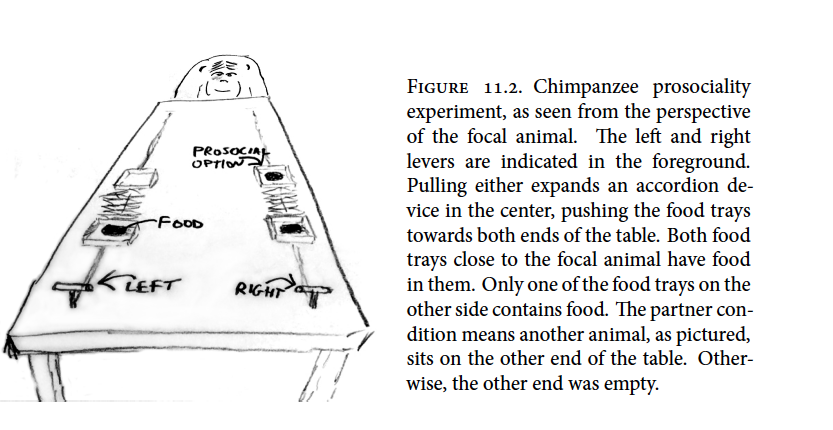

There are two experimental conditions. In the partner condition, another chimpanzee
is seated at the opposite end of the table, as pictured in Figure 11.2. In the control condition,
the other side of the table is empty. Finally, two counterbalancing treatments alternate
which side, left or right, has a food item for the other side of the table. This helps detect any
handedness preferences for individual focal animals.

In [28]:
d = pd.read_csv("Data/chimpanzees.csv", sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


We’re going to focus on pulled_left as the outcome to predict, with prosoc_left and
condition as predictor variables.

The outcome pulled_left is a 0 or 1 indicator that the
focal animal pulled the left-hand lever. The predictor prosoc_left is a 0/1 indicator that
the left-hand lever was (1) or was not (0) attached to the prosocial option, the side with two
pieces of food. 

The condition predictor is another 0/1 indicator, with value 1 for the partner
condition and value 0 for the control condition.


We’ll want to infer what happens in each combination of prosoc_left and condition.
There are four combinations:


(1) prosoc_left= 0 and condition= 0: Two food items on right and no partner.

(2) prosoc_left= 1 and condition= 0: Two food items on left and no partner.

(3) prosoc_left= 0 and condition= 1: Two food items on right and partner present.

(4) prosoc_left= 1 and condition= 1: Two food items on left and partner present

In [31]:
d["treatment"] = d.prosoc_left + 2 * d.condition # create an index variable for each combination call it treatment
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2



Now for our target model. Since this is an experiment, the structure tells us the model
relevant to inference. The model implied by the research question is, in mathematical form:

Li ∼ Binomial(1, pi)

logit(pi) = α<sub>actor[i]</sub> + β<sub>treatment[i]</sub>

αj ∼ to be determined

βk ∼ to be determined

Here L indicates the 0/1 variable pulled_left.

<h2> determine the priors </h2>

Lets start wtih the simplest model



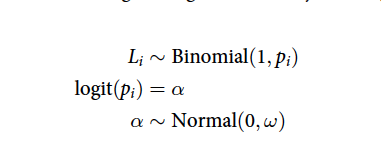

In [32]:
with pm.Model() as m11_1:
    a = pm.Normal("a", 0.0, 10.0)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1 = az.from_pymc3(prior=prior_11_1)

# need it to recreate the prior pred plot:
with pm.Model() as m11_1bis:
    a = pm.Normal("a", 0.0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_1bis = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_1bis = az.from_pymc3(prior=prior_11_1bis)

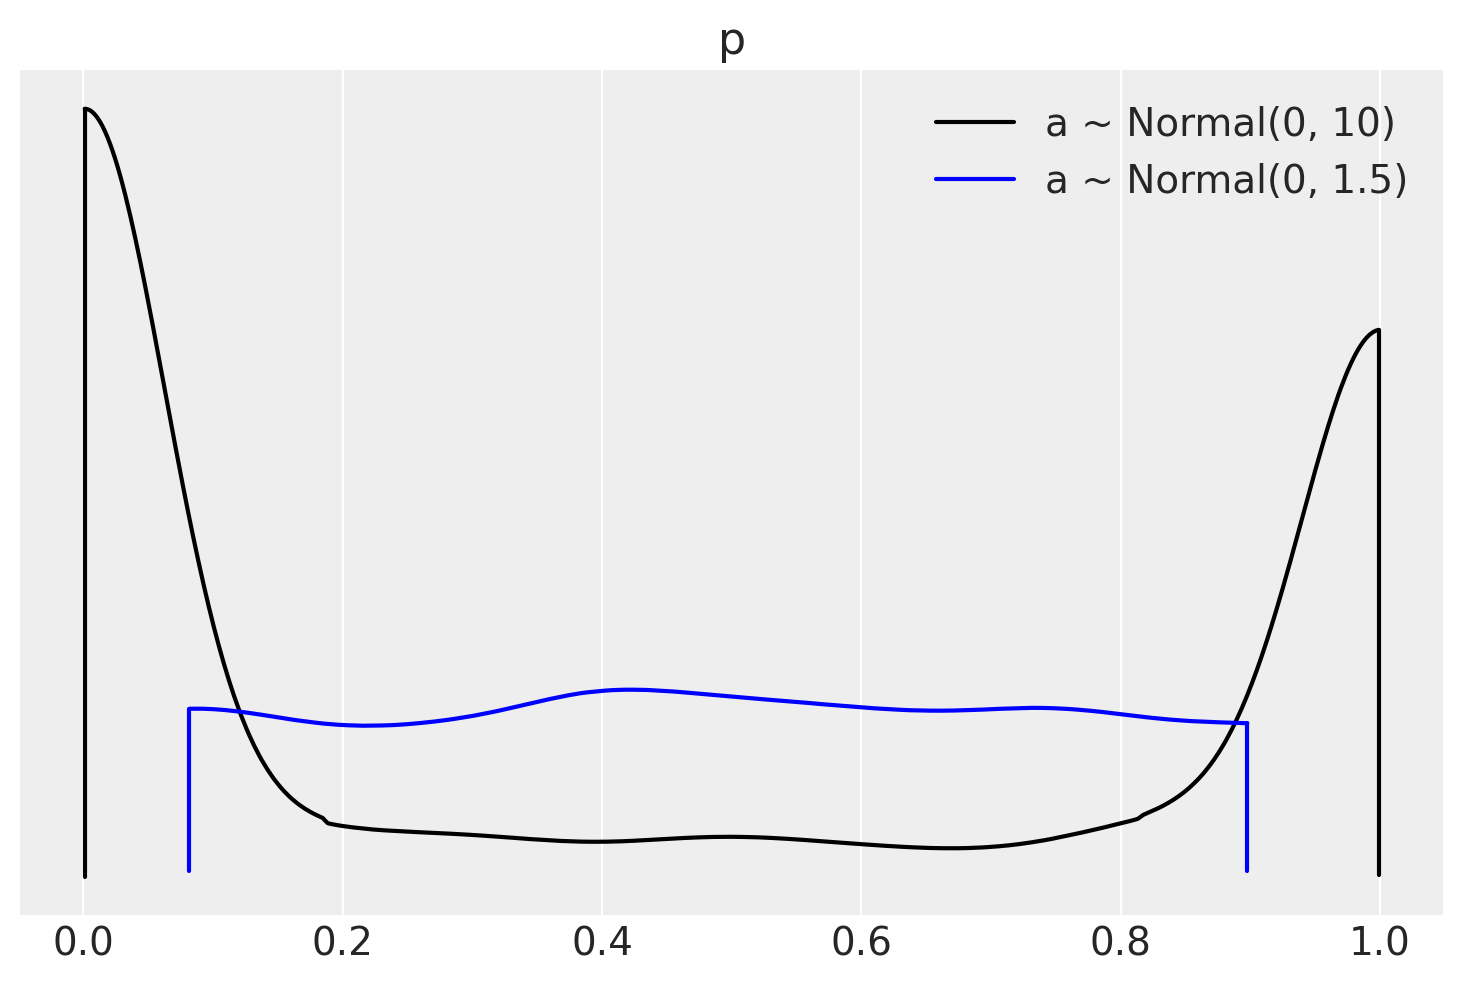

In [33]:
ax = az.plot_density(
    [idata_11_1, idata_11_1bis],
    data_labels=["a ~ Normal(0, 10)", "a ~ Normal(0, 1.5)"],
    group="prior",
    colors=["k", "b"],
    var_names=["p"],
    point_estimate=None,
)

#ax[0].set_xlabel("prior prob pull left")
#ax[0].set_ylabel("Density")
#ax[0].set_title("Prior predictive simulations for p");


In [35]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 10.0, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_2 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_2 = az.from_pymc3(prior=prior_11_2)
prior_2 = idata_11_2.prior

with pm.Model() as m11_3:
    a = pm.Normal("a", 0.0, 1.5)
    b = pm.Normal("b", 0.0, 0.5, shape=4)

    p = pm.math.invlogit(a + b[d.treatment])
    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    prior_11_3 = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
idata_11_3 = az.from_pymc3(prior=prior_11_3)
prior_3 = idata_11_3.prior

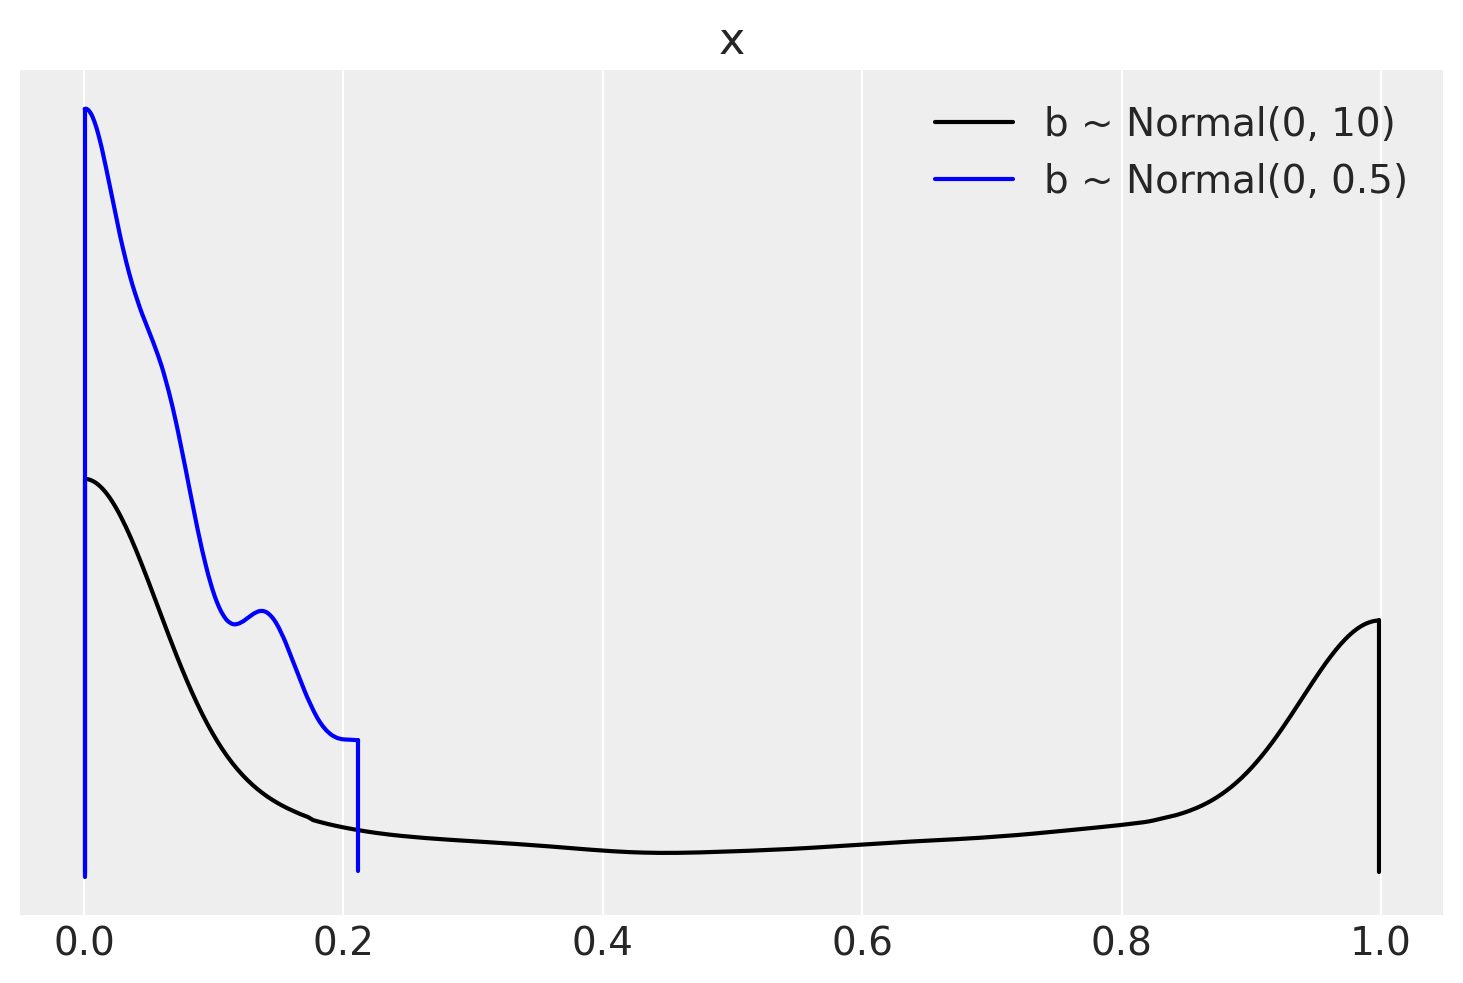

In [36]:
p_treat1, p_treat2 = (
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=0)),
    logistic(prior_2["a"] + prior_2["b"].sel(b_dim_0=1)),
)
p_treat1_bis, p_treat2_bis = (
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=0)),
    logistic(prior_3["a"] + prior_3["b"].sel(b_dim_0=1)),
)

ax = az.plot_density(
    [np.abs(p_treat1 - p_treat2).values, np.abs(p_treat1_bis - p_treat2_bis).values],
    data_labels=["b ~ Normal(0, 10)", "b ~ Normal(0, 0.5)"],
    group="prior",
    colors=["k", "b"],
    point_estimate=None,
)
#ax[0].set_xlabel("prior diff between treatments")
#ax[0].set_ylabel("Density")
#ax[0].set_title(None);

In [37]:
actor_idx, actors = pd.factorize(d.actor)
treat_idx, treatments = pd.factorize(d.treatment)

In [38]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0.0, 1.5, shape=len(actors))
    b = pm.Normal("b", 0.0, 0.5, shape=len(treatments))

    actor_id = pm.intX(pm.Data("actor_id", actor_idx))
    treat_id = pm.intX(pm.Data("treat_id", treat_idx))
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treat_id]))

    pulled_left = pm.Binomial("pulled_left", 1, p, observed=d.pulled_left)

    trace_11_4 = pm.sample(random_seed=RANDOM_SEED)
idata_11_4 = az.from_pymc3(trace_11_4)
az.summary(idata_11_4, var_names=["a", "b"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.45,0.34,-0.99,0.09,0.01,0.01,634.39,634.39,634.24,1172.38,1.0
a[1],3.89,0.77,2.68,5.13,0.02,0.02,1277.25,1178.01,1337.08,971.45,1.0
a[2],-0.75,0.34,-1.29,-0.22,0.01,0.01,782.79,782.79,780.58,1244.69,1.0
a[3],-0.75,0.34,-1.32,-0.22,0.01,0.01,687.36,687.36,690.40,1269.98,1.0
a[4],-0.44,0.34,-0.94,0.14,0.01,0.01,689.11,689.11,686.31,947.16,1.0
a[5],0.47,0.35,-0.05,1.05,0.01,0.01,714.46,714.46,714.06,1233.24,1.0
a[6],1.96,0.43,1.26,2.60,0.02,0.01,761.05,742.77,774.52,1000.49,1.0
b[0],-0.04,0.29,-0.47,0.44,0.01,0.01,657.81,657.81,660.27,1140.69,1.0
b[1],0.48,0.29,0.03,0.96,0.01,0.01,659.09,659.09,664.58,1215.99,1.0
b[2],-0.38,0.30,-0.82,0.12,0.01,0.01,594.99,594.99,595.11,994.44,1.0


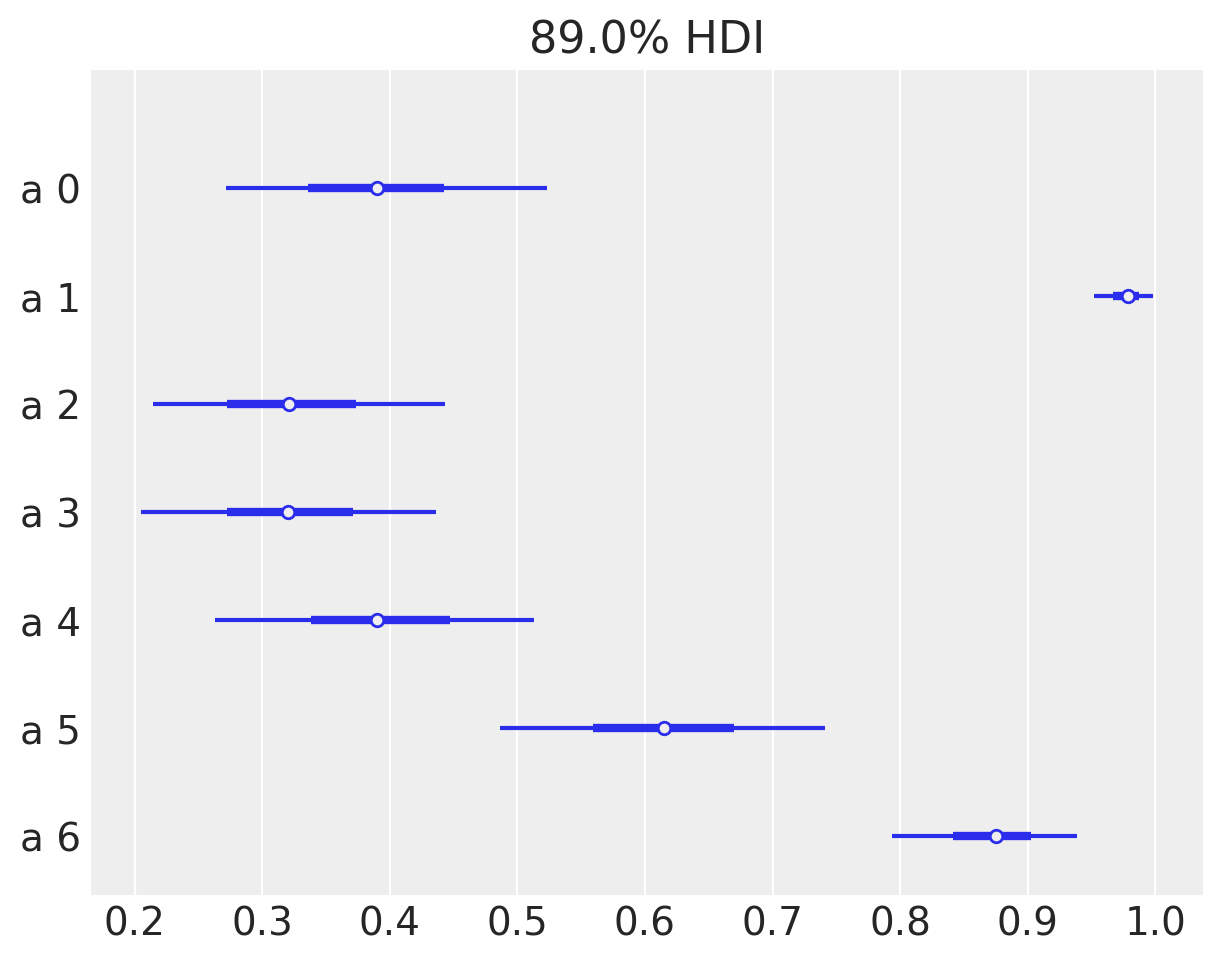

In [39]:

#Let’s look at these on the outcome scale:
az.plot_forest(idata_11_4, var_names=["a"], transform=logistic, combined=True);



Each row is a chimpanzee, the numbers corresponding to the values in actor. Four of the
individuals—numbers 1, 3, 4, and 5—show a preference for the right lever. Two individuals—
numbers 2 and 7—show the opposite preference. Number 2’s preference is very strong indeed.
If you inspect the data, you’ll see that actor 2 never once pulled the right lever in
any trial or treatment. There are substantial differences among the actors in their baseline
tendencies.

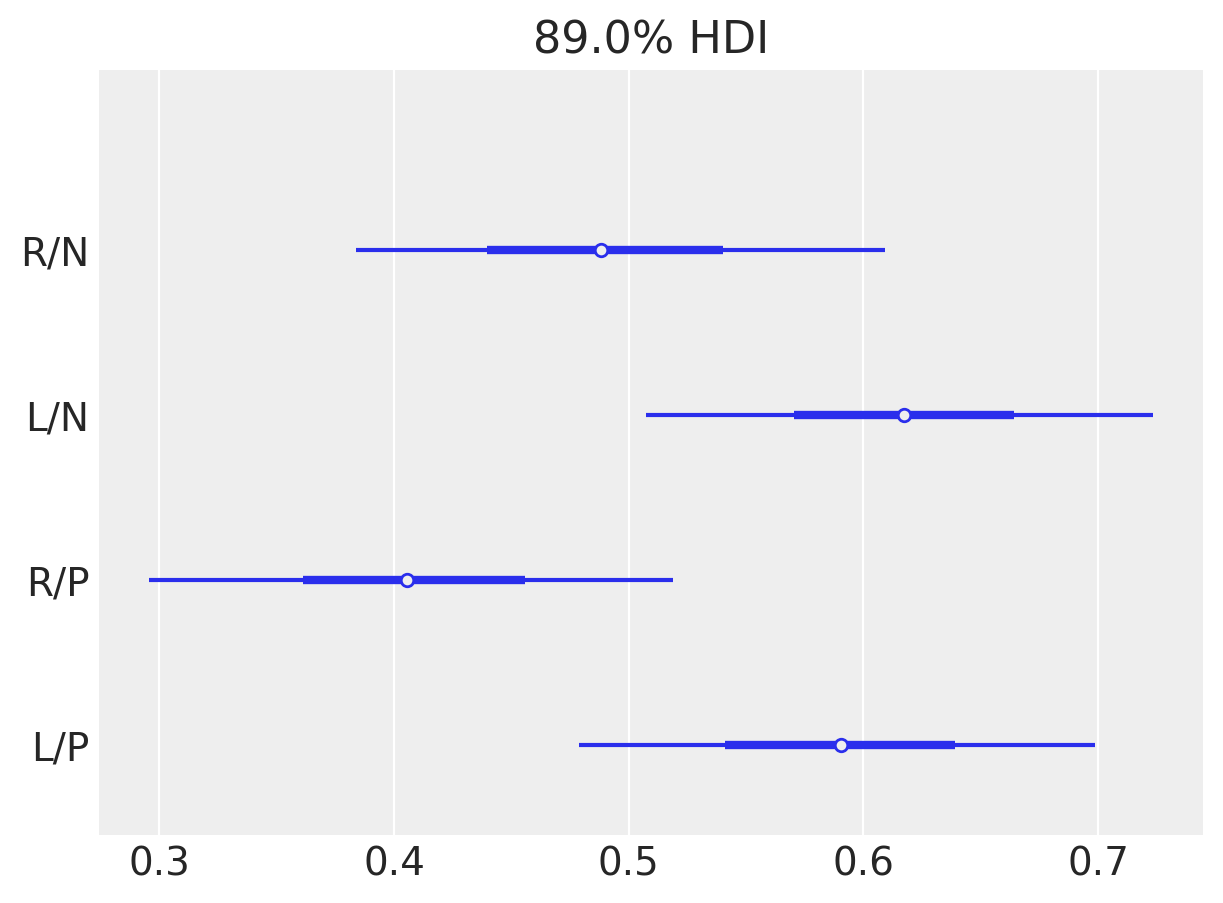

In [40]:
# on the loigt scale  and subtract out the handedness variation among actors
#L/N means “prosocial on left /no partner.” R/P means ”prosocial on right / partner.”
#ax = az.plot_forest(idata_11_4, var_names=["b"], transform=logistic,combined=True)
#L/N means “prosocial on left /no partner.” R/P means ”prosocial on right / partner.”
ax = az.plot_forest(idata_11_4, var_names=["b"],transform=logistic,combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);

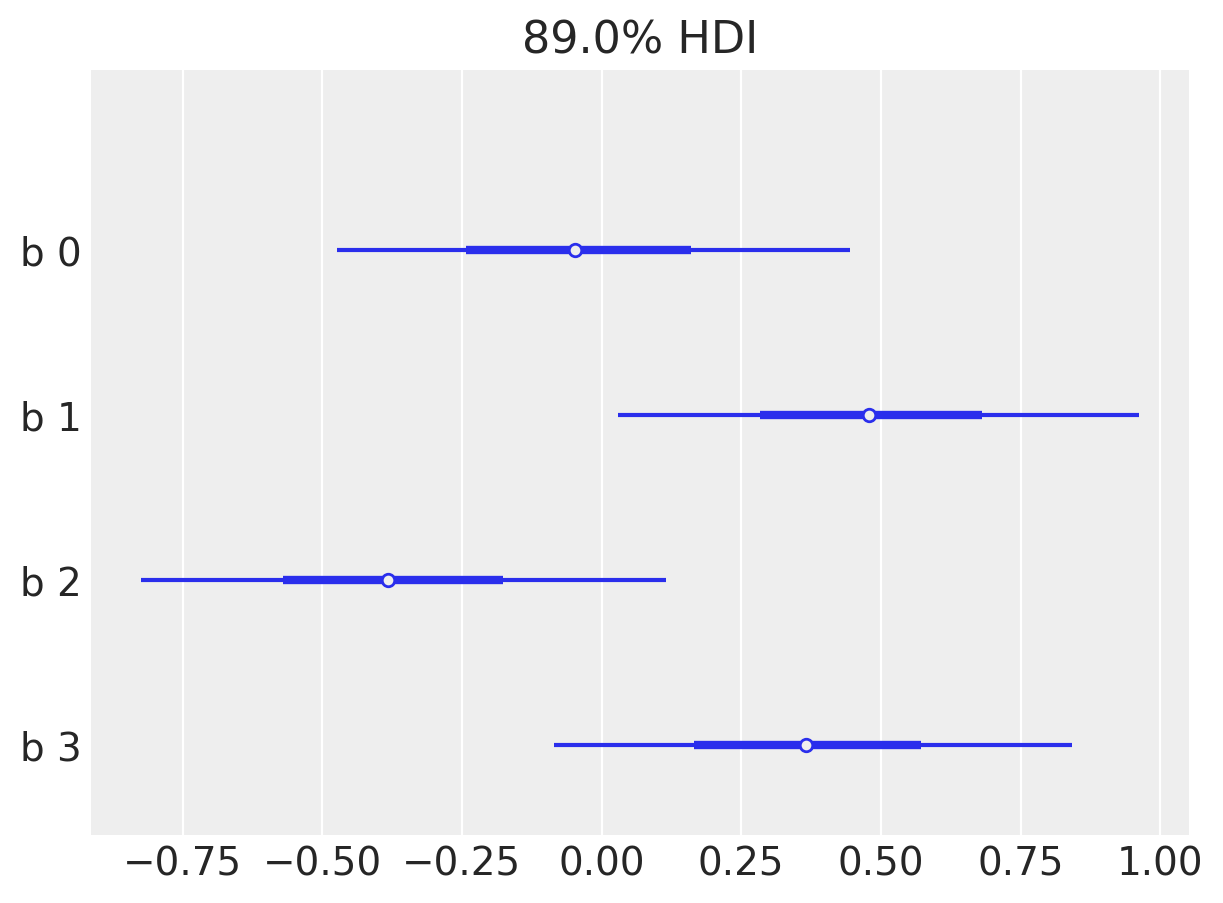

In [41]:
ax = az.plot_forest(idata_11_4, var_names=["b"],combined=True)

What we are looking for is evidence that the chimpanzees
choose the prosocial option more when a partner is present. This implies comparing the
first row with the third row and the second row with the fourth row. You can probably see
already that there isn’t much evidence of prosocial intention in these data. But let’s calculate
the differences between no-partner/partner and make sure.


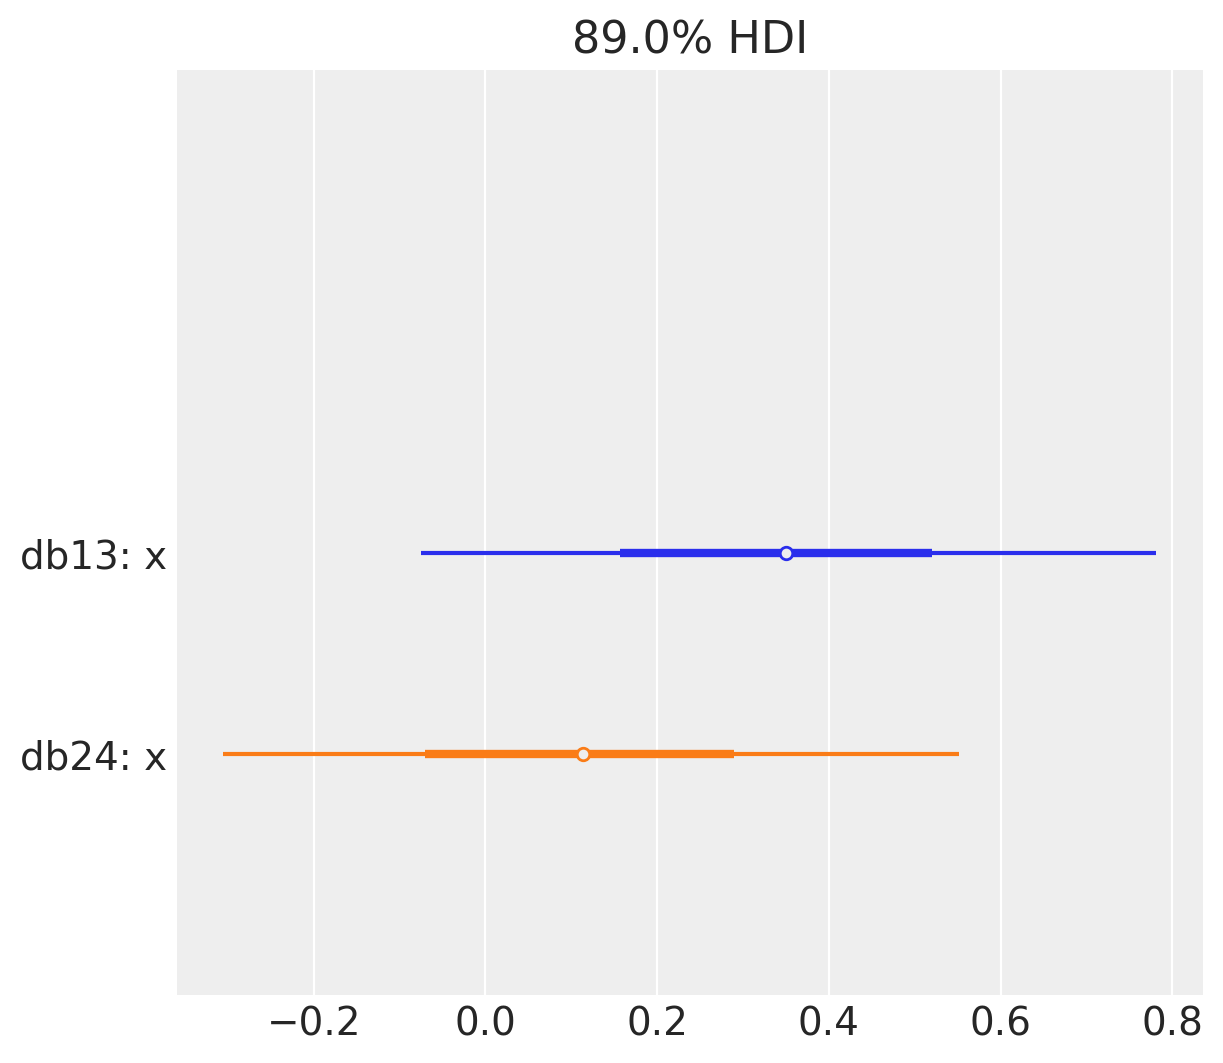

In [19]:
db13 = idata_11_4.posterior["b"].sel(b_dim_0=0) - idata_11_4.posterior["b"].sel(b_dim_0=2)
db24 = idata_11_4.posterior["b"].sel(b_dim_0=1) - idata_11_4.posterior["b"].sel(b_dim_0=3)
az.plot_forest([db13.values, db24.values], model_names=["db13", "db24"], combined=True);


These are the constrasts between the no-partner/partner treatments.
The scale is logodds of pulling the left lever still. 


 db13 is the difference between
no-partner/partner treatments when the prosocial option was on the right. So if there is
evidence of more prosocial choice when partner is present, this will show up here as a larger
difference, consistent with pulling right more when partner is present. There is indeed weak
evidence that individuals pulled left more when the partner was absent, but the compatibility
interval is quite wide.

db24 is the same difference, but for when the prosocial option was on
the left. Now negative differences would be consistent with more prosocial choice when
partner is present. Clearly that is not the case. If anything, individuals chose prosocial more
when partner was absent. Overall, there isn’t any compelling evidence of prosocial choice in
this experiment.

<h1>posterior prediction check</h1>.
Let’s summarize the proportions of left
pulls for each actor in each treatment and then plot against the posterior predictions. First,
to calculate the proportion in each combination of actor and treatment:

In [42]:
pl = d.groupby(["actor", "treatment"]).agg("mean")["pulled_left"].unstack()
pl


treatment,0,1,2,3
actor,,,,
0,0.333333,0.500000,0.277778,0.555556
1,1.000000,1.000000,1.000000,1.000000
2,0.277778,0.611111,0.166667,0.333333
3,0.333333,0.500000,0.111111,0.444444
4,0.333333,0.555556,0.277778,0.500000
5,0.777778,0.611111,0.555556,0.611111
6,0.777778,0.833333,0.944444,1.000000


The result pl is a matrix with 7 rows and 4 columns. Each row is an individual chimpanzee.
Each column is a treatment. And the cells contain proportions of pulls that were of the left
lever. Above is the first row, showing the proportions for the first actor. The model will make
predictions for these values, so we can see how the posterior predictions look against the raw
data. Remember that we don’t want an exact match—that would mean overfitting. But we
would like to understand how the model sees the data and learn from any anomalies

In [44]:
with m11_4:
    pm.set_data({"actor_id": np.repeat(range(7), 4), "treat_id": list(range(4)) * 7})
    p_post = pm.sample_posterior_predictive(trace_11_4, random_seed=RANDOM_SEED, var_names=["p"])[
        "p"
    ]
p_mu = p_post.mean(0).reshape((7, 4))

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:334: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
<ipython-input-45-1b541e14ee20>:90: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout();


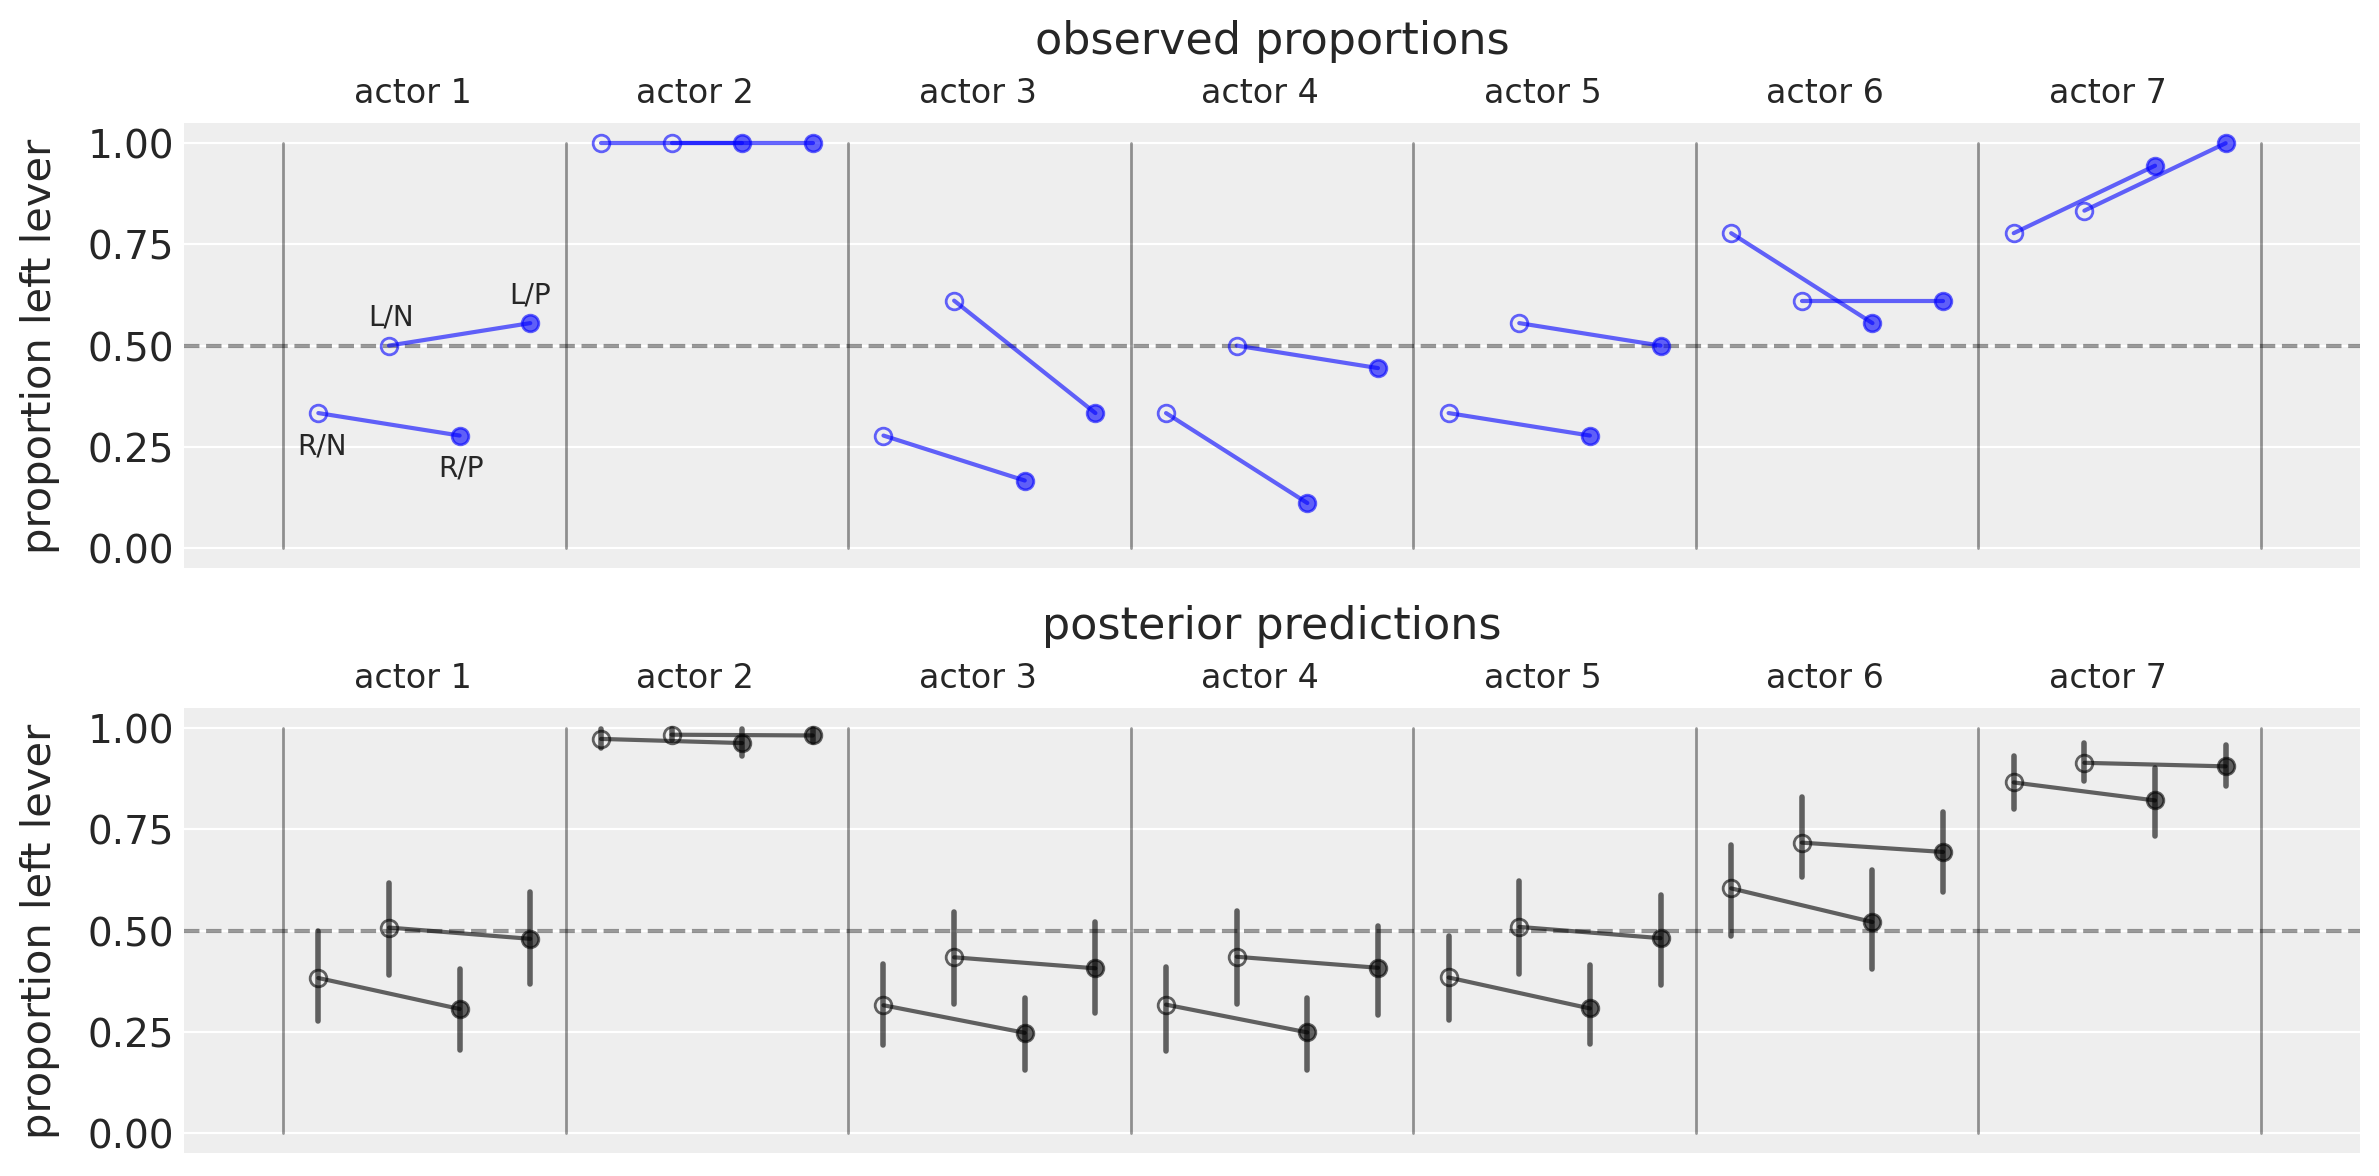

In [45]:
pl_val = pl.stack().values
_, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
alpha, xoff, yoff = 0.6, 0.3, 0.05

ax0.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax0.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax0.plot(
        [actor * 4, actor * 4 + 2],
        [pl.loc[actor, 0], pl.loc[actor, 2]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [pl.loc[actor, 1], pl.loc[actor, 3]],
        "-",
        c="b",
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4, actor * 4 + 1],
        [pl.loc[actor, 0], pl.loc[actor, 1]],
        "o",
        c="b",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax0.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [pl.loc[actor, 2], pl.loc[actor, 3]],
        "o",
        c="b",
        ms=6,
        alpha=alpha,
    )
    ax0.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax0.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
    if actor == 0:
        ax0.text(actor * 4 - xoff, pl.loc[actor, 0] - 2 * yoff, "R/N")
        ax0.text(actor * 4 + 1 - xoff, pl.loc[actor, 1] + yoff, "L/N")
        ax0.text(actor * 4 + 2 - xoff, pl.loc[actor, 2] - 2 * yoff, "R/P")
        ax0.text(actor * 4 + 3 - xoff, pl.loc[actor, 3] + yoff, "L/P")
ax0.set_xticks([])
ax0.set_ylabel("proportion left lever", labelpad=10)
ax0.set_title("observed proportions", pad=25)

ax1.plot([range(28), range(28)], az.hpd(p_post).T, "k-", lw=2, alpha=alpha)
ax1.plot([7 * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
ax1.axhline(0.5, ls="--", c="k", alpha=0.4)
for actor in range(len(actors)):
    ax1.plot(
        [actor * 4, actor * 4 + 2],
        [p_mu[actor, 0], p_mu[actor, 2]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 1, actor * 4 + 3],
        [p_mu[actor, 1], p_mu[actor, 3]],
        "-",
        c="k",
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4, actor * 4 + 1],
        [p_mu[actor, 0], p_mu[actor, 1]],
        "o",
        c="k",
        fillstyle="none",
        ms=6,
        alpha=alpha,
    )
    ax1.plot(
        [actor * 4 + 2, actor * 4 + 3],
        [p_mu[actor, 2], p_mu[actor, 3]],
        "o",
        c="k",
        ms=6,
        alpha=alpha,
    )
    ax1.plot([actor * 4 - 0.5] * 2, [0, 1], c="k", alpha=0.4, lw=1)
    ax1.text(actor * 4 + 0.5, 1.1, f"actor {actor + 1}", fontsize=12)
ax1.set_xticks([])
ax1.set_ylabel("proportion left lever", labelpad=10)
ax1.set_title("posterior predictions", pad=25)
plt.tight_layout();

The open points are the  non-partner treatments. 
The filled points are the partner treatments. 
Then the first point
in each open/filled pair is prosocial on the right. The second is prosocial on the left. Each
group of four point is an individual actor, labeled at the top.

The model expects almost no change when adding a partner. Most of the variation in predictions
comes from the actor intercepts. Handedness seems to be the big story of this experiment.
The data themselves show additional variation—some of the actors possibly respond
more to the treatments than others do. We might consider a model that allows each unique
actor to have unique treatment parameters. But we’ll leave such a model until we arrive at
multilevel models, because we’ll need some additional tricks to do the model well.